c:\users\shikugawa\miniconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Epoch 1/20
28562/28562 [==============================] - 22s 754us/step - loss: 21247550587.5096
Epoch 2/20
28562/28562 [==============================] - 20s 693us/step - loss: 2322716901.2456
Epoch 3/20
28562/28562 [==============================] - 20s 693us/step - loss: 3341258518.1385
Epoch 4/20
28562/28562 [==============================] - 20s 694us/step - loss: 2168718460.5313
Epoch 5/20
28562/28562 [==============================] - 20s 696us/step - loss: 2145472067.9751
Epoch 6/20
28562/28562 [==============================] - 20s 698us/step - loss: 4830104490.6009
Epoch 7/20
28562/28562 [==============================] - 20s 697us/step - loss: 2150090490.3802
Epoch 8/20
28562/28562 [==============================] - 20s 704us/step - loss: 2150938747.7336
Epoch 9/20
28562/28562 [==============================] - 21s 732us/step - loss: 1941043288.6437
Epoch 10/20
28562/28562 [==============================] - 20s 709us/step - loss: 1494533743.7233
Epoch 11/20
28562/28562 [===

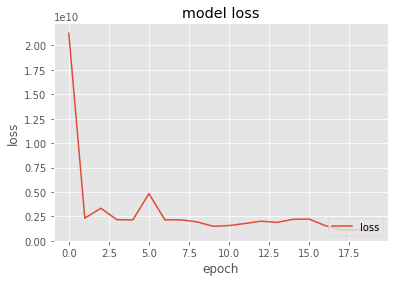

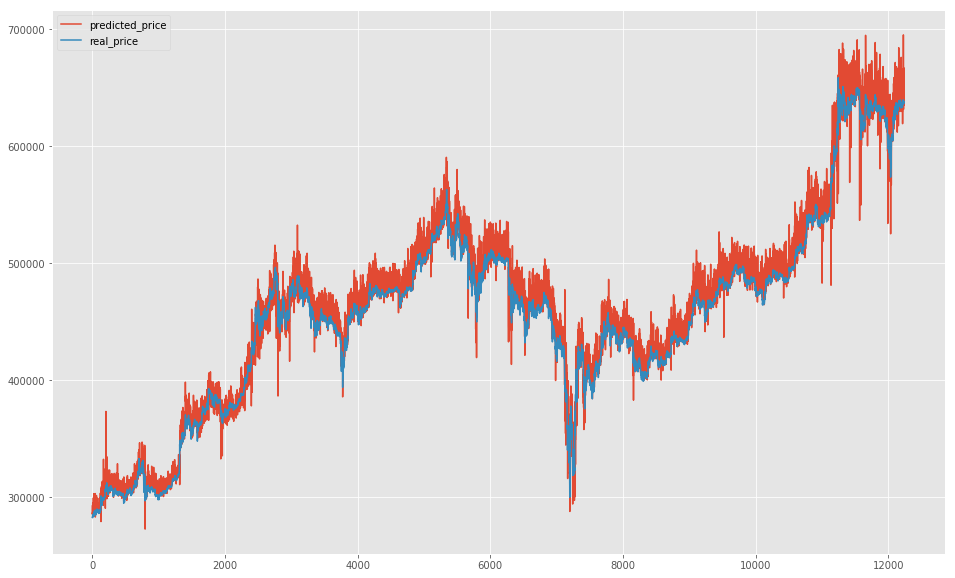

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import re

%matplotlib inline
plt.style.use('ggplot')

class TechnicalTerm():
    @classmethod
    def bolinger_band(self, raw_data):
        bolinger_option = ["bolinger_upper1", "bolinger_lower1", "bolinger_upper2", "bolinger_lower2"]
        base = raw_data[["Close"]].rolling(window=25).mean()
        std = raw_data[["Close"]].rolling(window=25).std()

        for opt in bolinger_option:
            if opt == "bolinger_upper1":
                raw_data[opt] = base + std
            elif opt == "bolinger_lower1":
                raw_data[opt] = base - std
            elif opt == "bolinger_upper2":
                raw_data[opt] = base + 2 * std
            elif opt == "bolinger_lower2":
                raw_data[opt] = base - 2 * std

        data = raw_data.dropna()
        return data

    @classmethod
    def conversion(self, raw_data):
        raw_data["rol_high"] = raw_data[["High"]].rolling(window=9*60*24).max()
        raw_data["rol_low"] = raw_data[["Low"]].rolling(window=9*60*24).min()
        raw_data = raw_data.dropna()

        high = raw_data[["rol_high"]].values
        low = raw_data[["rol_low"]].values
        raw_data["conversion"] = np.reshape((high + low) / 2, (-1, ))
        data = raw_data

        return data
    
def create_data(data, label_data, term):
    created_data = []
    nested_data = []
    label = []

    label_data= np.reshape(label_data, (-1, ))
    for index, dt in enumerate(data):
        nested_data.append(dt)

        if len(nested_data) == term:
            created_data.append(nested_data)
            label.append(label_data[index])
            nested_data = []

    label = np.reshape(np.array(label), (-1, ))
    return np.array(created_data), label

def split_data(train, label, testing_rate=0.7):
    train_x, test_x = train[1:int(len(train) * testing_rate)], train[1 + int(len(train) * testing_rate):len(train)]
    train_y, test_y = label[1:int(len(label) * testing_rate)], label[1 + int(len(label) * testing_rate):len(label)]
    return train_x, train_y, test_x, test_y

def training(x_train, y_train, x_test, y_test, term, option_length, neurons=128, dropout=0.25, epoch=20):
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(None, term, option_length),
                   recurrent_regularizer=regularizers.l2(0.), activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))

    model.compile(loss="mean_squared_error", optimizer="adam")

    # -------------training-------------
    output = model.fit(x_train, y_train, epochs=epoch, verbose=1)

    predicted_price = model.predict(x_test)
    datas = pd.DataFrame(
        data = {
            'real_price': np.reshape(y_test, (-1, )),
            'predicted_price': np.reshape(predicted_price, (-1, ))
        }
    )
    
    plt.plot(output.history['loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss'], loc='lower right')
    
    datas.plot(figsize=(16, 10))
    plt.show()
    print(mean_absolute_error(np.reshape(y_test, (-1, )),
                             np.reshape(predicted_price, (-1, ))))

raw_data = pd.read_csv("../coin.csv").dropna()

# append hour
hour = []
hour_data = np.reshape(raw_data[["Timestamp"]].values, (-1, ))
for timestamp in hour_data:
    time = datetime.datetime.fromtimestamp(int(timestamp))
    hour.append(re.match(r"\d{4}-\d{1,2}-\d{1,2} (\d\d):\d\d:\d\d", str(time)).group(1))

raw_data["Hour"] = hour
raw_data = raw_data.drop(["Timestamp"], axis=1)

# append bolinger band
raw_data = TechnicalTerm.bolinger_band(raw_data)
# append conversion line
raw_data = TechnicalTerm.conversion(raw_data)

options = ["Open", "High", "Low", "Close", "Volume_(BTC)", "Volume_(Currency)", "Hour",
           "bolinger_upper1", "bolinger_lower1", "bolinger_upper2", "bolinger_lower2", "conversion"]
df_train = raw_data[options]
df_label = raw_data[["Weighted_Price"]]
term = 10

x_train, y_train, x_test, y_test = split_data(df_train, df_label)

# ----train data noramlization---------
x_train = x_train[options].values
y_train = y_train.values
x_train, y_train = create_data(x_train, y_train, term)
# -------------------------------------

# ----train data noramlization---------
x_test = x_test[options].values
y_test = y_test.values
x_test, y_test = create_data(x_test, y_test, term)
# -------------------------------------

training(x_train, y_train, x_test, y_test, term, len(options), neurons=128, dropout=0.25, epoch=20)

